# Imports

In [1]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.3/139.3 kB 2.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.1/82.1 kB 6.5 MB/s eta 0:00:00


In [2]:
import os
import pandas as pd
import boto3
from botocore import UNSIGNED
from botocore.config import Config
import matplotlib.pyplot as plt

# Constants

In [3]:
# Change path depending on where data is located
data_root = 'LOCAL_PATH_TO_DATA'
column_names = ['ID', 'DATE', 'ELEMENT', 'DATA VALUE', 'M-FLAG', 'Q-FLAG', 'S-FLAG', 'OBS-TIME']

# Data

## Setup Bucket connection

In [4]:
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
s3_resource = boto3.resource("s3", config=Config(signature_version=UNSIGNED))
bucket = s3_resource.Bucket('noaa-ghcn-pds')

## Download files in batches

In [5]:
size = 0
for obj in bucket.objects.all():
    if 'by_station' not in obj.key:
        size += 1
    else:
        break

print('Number of yearly files: ', size)

Number of yearly files:  260


In [6]:
years = []
for obj in bucket.objects.all():
    if 'by_station' not in obj.key:
        _, filename = os.path.split(obj.key)
        local_path = data_root + filename
        if not os.path.isfile(local_path):
            print(filename, ' downloaded')
            years.append(filename.split('.')[0])
            s3_client.download_file('noaa-ghcn-pds', obj.key, local_path)
    else:
        break

1763.csv.gz  downloaded
1764.csv.gz  downloaded
1765.csv.gz  downloaded
1766.csv.gz  downloaded
1767.csv.gz  downloaded
1768.csv.gz  downloaded
1769.csv.gz  downloaded
1770.csv.gz  downloaded
1771.csv.gz  downloaded
1772.csv.gz  downloaded
1773.csv.gz  downloaded
1774.csv.gz  downloaded
1775.csv.gz  downloaded
1776.csv.gz  downloaded
1777.csv.gz  downloaded
1778.csv.gz  downloaded
1779.csv.gz  downloaded
1780.csv.gz  downloaded
1781.csv.gz  downloaded
1782.csv.gz  downloaded
1783.csv.gz  downloaded
1784.csv.gz  downloaded
1785.csv.gz  downloaded
1786.csv.gz  downloaded
1787.csv.gz  downloaded
1788.csv.gz  downloaded
1789.csv.gz  downloaded
1790.csv.gz  downloaded
1791.csv.gz  downloaded
1792.csv.gz  downloaded
1793.csv.gz  downloaded
1794.csv.gz  downloaded
1795.csv.gz  downloaded
1796.csv.gz  downloaded
1797.csv.gz  downloaded
1798.csv.gz  downloaded
1799.csv.gz  downloaded
1800.csv.gz  downloaded
1801.csv.gz  downloaded
1802.csv.gz  downloaded
1803.csv.gz  downloaded
1804.csv.gz  dow

In [7]:
list(map(int, years))
print('First year recorded: ', min(years))
print('Last year recorded: ', max(years))

First year recorded:  1763
Last year recorded:  2022


#Load file

In [8]:
import matplotlib.pyplot as plt

In [9]:
def load_df(year):
    df = pd.read_csv(data_root + str(year) + '.csv.gz', header = 0, names = column_names)

    df['COUNTRY'] = df['ID'].str[:2]
    df['STATION'] = df['ID'].str[2:]
    df['DATE'] = pd.to_datetime(df['DATE'])

    return df

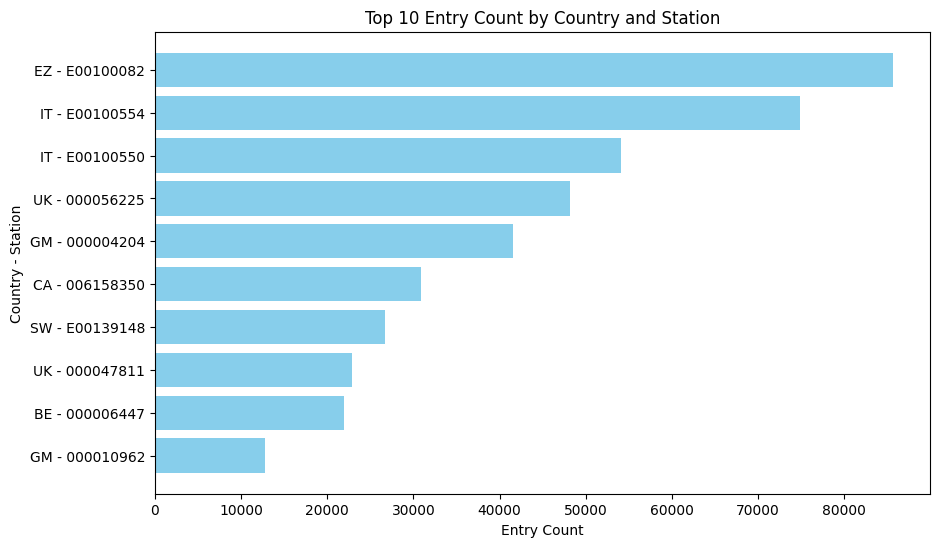

,COUNTRY,FIRST_YEAR
49,IT,1763
46,IT,1763
40,EZ,1775
41,GM,1781
42,GM,1781
72,UK,1814
71,UK,1814
37,BE,1833
67,SW,1836
38,CA,1840


In [17]:
def oldest_countries():
    years_range = range(int(min(years)), int(min(years)) + 100)
    oldest = pd.DataFrame()
    country_first_year = {}

    for year in years_range:
        old = load_df(year)
        oldest = pd.concat([oldest, old], axis=0)
        for country in old['COUNTRY'].unique():
            if country not in country_first_year or year < country_first_year[country]:
                country_first_year[country] = year

    grouped = oldest.groupby(['COUNTRY', 'STATION']).size().reset_index(name='ENTRY_COUNT')
    grouped_data_sorted = grouped.sort_values(by='ENTRY_COUNT', ascending=False)

    top_10 = grouped_data_sorted.head(10)

    # Plotting the results
    plt.figure(figsize=(10, 6))
    plt.barh(range(len(top_10)), top_10['ENTRY_COUNT'], color='skyblue')
    plt.yticks(range(len(top_10)), [f"{country} - {station}" for country, station in zip(top_10['COUNTRY'], top_10['STATION'])])
    plt.xlabel('Entry Count')
    plt.ylabel('Country - Station')
    plt.title('Top 10 Entry Count by Country and Station')
    plt.gca().invert_yaxis()  # Invert y-axis to have the highest count on top
    plt.show()

    # Displaying the top 10 countries with their first appearance year
    top_10_with_years = top_10.copy()
    top_10_with_years['FIRST_YEAR'] = [country_first_year[country] for country in top_10_with_years['COUNTRY']]
    top_10_with_years = top_10_with_years.sort_values(by='FIRST_YEAR')
    return top_10_with_years[['COUNTRY', 'FIRST_YEAR']]

oldest_countries()